In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
from math import sin, cos, pi
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

In [5]:
def gaussian_filter(a, kernel, sigma):
    '''
    padding: padding size
    kernel : kernel size
    stride : stride
    sigma  : smooth is control by σ，σ more bigger is more smooth and more blur
    '''
    padding = kernel//2
    kernel = kernel
    stride = 1   # same size of input and output
    
    # create empty matrix
    temp = np.zeros((a.shape[0] + 2*padding, a.shape[1] + 2*padding))  
    blur = np.zeros((a.shape[0], a.shape[1]))  

    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            temp[i+padding][j+padding] = a[i][j]
    
    # gaussian kernel
    x, y = np.mgrid[-(kernel//2):(kernel//2)+1, -(kernel//2):(kernel//2)+1]
    gaussian_kernel = (1/(2*pi*sigma**2))*np.exp(-(x**2+y**2)/(2*(sigma**2)))

    # gaussian filter
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            blur[i][j] = (temp[stride*i:stride*i+kernel, stride*j:stride*j+kernel]*gaussian_kernel).sum()
            
    return blur


def Filter(a, Type, kernel=3):
    '''
    padding: padding size
    kernel: kernel size
    stride: stride
    '''
    padding = kernel//2
    kernel = kernel
    stride = 1   # same size of input and output
    
    # create empty matrix
    temp = np.zeros((a.shape[0] + 2*padding, a.shape[1] + 2*padding))  
    blur = np.zeros((a.shape[0], a.shape[1]))  
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            temp[i+padding][j+padding] = a[i][j]
    
    # kernel
    if Type == "sobel_h":
        KERNEL = np.array([[-1,-2,-1],
                           [0,0,0],
                           [1,2,1]])
    elif Type == "sobel_v":
        KERNEL = np.array([[-1,0,1],
                           [-2,0,2],
                           [-1,0,1]])
    elif Type == "prewitt_h":
        KERNEL = np.array([[-1,-1,-1],
                           [0,0,0],
                           [1,1,1]])
    elif Type == "prewitt_v":
        KERNEL = np.array([[-1,0,1],
                           [-1,0,1],
                           [-1,0,1]])
    else:
        KERNEL = np.array([[0,-1,0],
                           [-1,4,-1],
                           [0,-1,0]])
    
    # filter
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            blur[i][j] = (temp[stride*i:stride*i+kernel, stride*j:stride*j+kernel]*KERNEL).sum()
  
    return blur


#  Y' = 0.299 R + 0.587 G + 0.114 B 
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


def showImg(image):
    plt.imshow(image, cmap='Greys_r')
    plt.show()

    
def readImg2Gray(path, resize=False):
    image     = plt.imread(path)
    if resize:
        image = cv2.resize(image, None, fx=0.3, fy=0.3)
    
    image_gray = rgb2gray(image)  
    showImg(image)
    showImg(image_gray)
    return image_gray


def sobel(image):
    sobel_h = Filter(image, Type="sobel_h", kernel=3)
    sobel_v = Filter(image, Type="sobel_v", kernel=3)
    sobel   = np.absolute(sobel_h) + np.absolute(sobel_v)
    return sobel


def scale(image, threshold=70):
    shape = image.shape
    image_scaled = minmax_scale(image.ravel(), feature_range=(0,255)).reshape(shape)
    image_scaled[image_scaled >= threshold] = 255
    image_scaled[image_scaled < threshold] = 0
    return image_scaled

# Read image

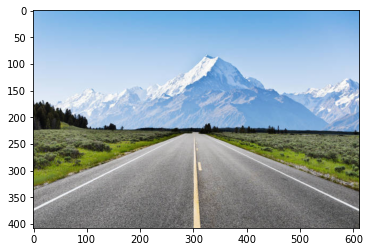

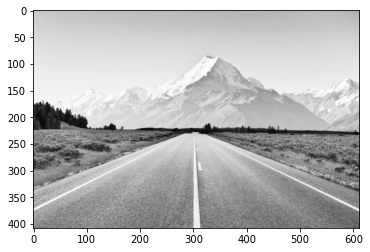

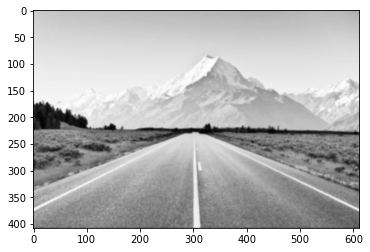

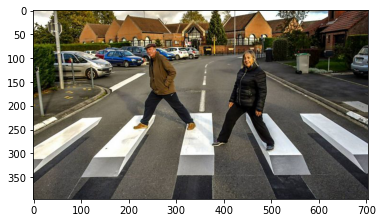

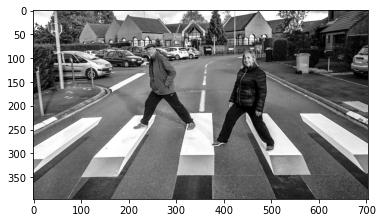

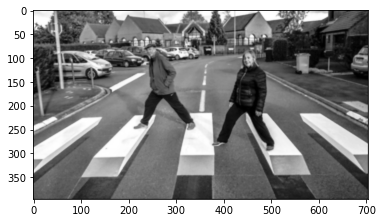

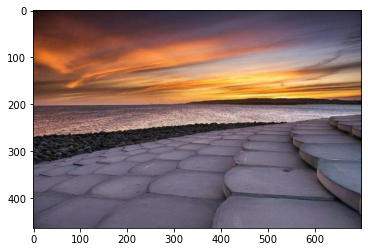

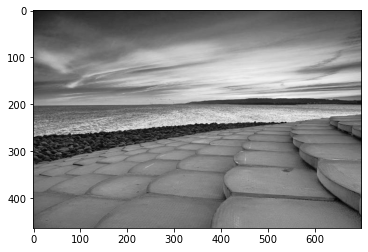

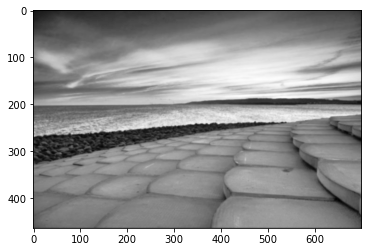

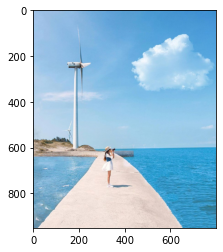

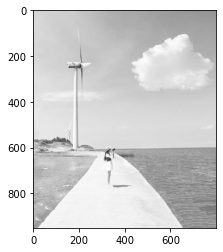

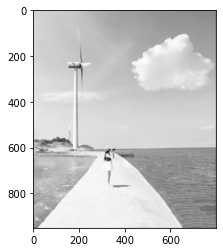

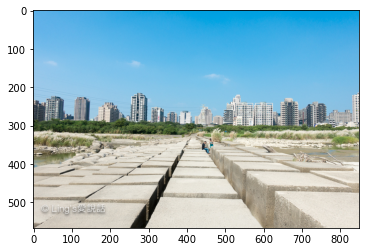

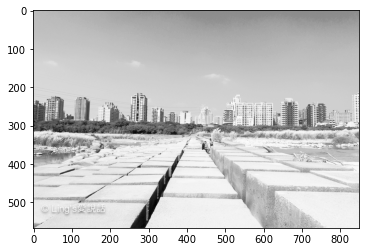

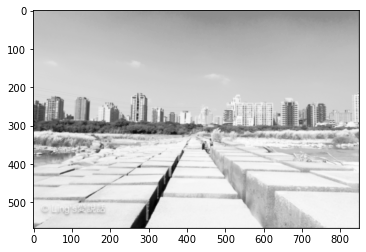

In [102]:
scene_gray     = readImg2Gray("pic4PR2/scene.jpg")
scene_gaussian = gaussian_filter(scene_gray, kernel=13, sigma=1)
showImg(scene_gaussian)

# #--------------------------------------------------------------------#
crossing_gray     = readImg2Gray("pic4PR2/crossing.jpg")
crossing_gaussian = gaussian_filter(crossing_gray, kernel=13, sigma=1)
showImg(crossing_gaussian)

# #--------------------------------------------------------------------#
fish_gray     = readImg2Gray("pic4PR2/fish.jpg")
fish_gaussian = gaussian_filter(fish_gray, kernel=13, sigma=1)
showImg(fish_gaussian)

# #--------------------------------------------------------------------#
sea_gray     = readImg2Gray("pic4PR2/sea.jpg")
sea_gaussian = gaussian_filter(sea_gray, kernel=13, sigma=1)
showImg(sea_gaussian)

# #--------------------------------------------------------------------#
tofu_gray     = readImg2Gray("pic4PR2/tofu.jpg")
tofu_gaussian = gaussian_filter(tofu_gray, kernel=39, sigma=1)
showImg(tofu_gaussian)

# Use sobel to image gradients

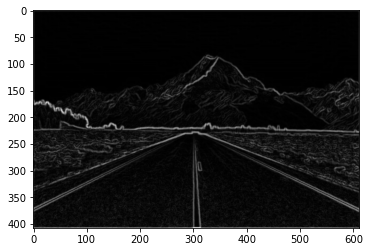

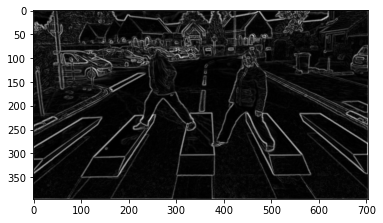

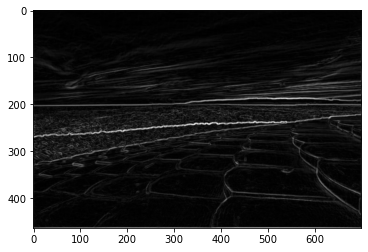

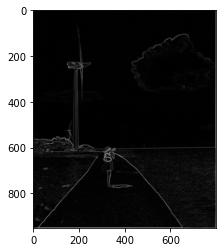

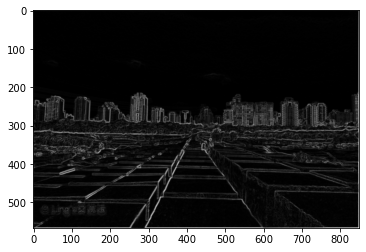

In [85]:
scene_sobel    = sobel(scene_gaussian)
crossing_sobel = sobel(crossing_gaussian)
fish_sobel     = sobel(fish_gaussian)
sea_sobel      = sobel(sea_gaussian)
tofu_sobel     = sobel(tofu_gaussian)

showImg(scene_sobel)
showImg(crossing_sobel)
showImg(fish_sobel)
showImg(sea_sobel)
showImg(tofu_sobel)

# scale to [0, 255] and set image gradient threshold

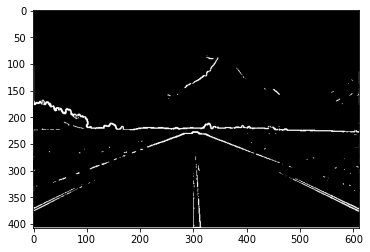

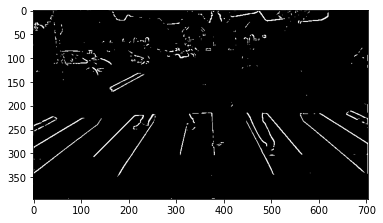

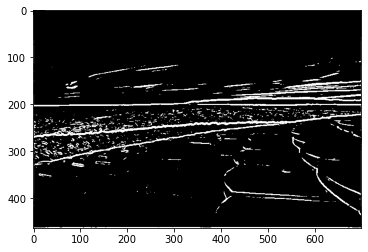

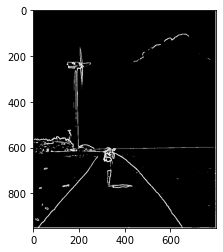

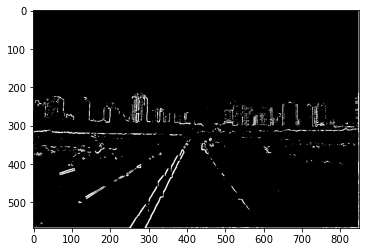

In [84]:
# 範圍to[0,255]
scene_sobel_scaled = scale(scene_sobel, 70)
crossing_sobel_scaled = scale(crossing_sobel, 100)
fish_sobel_scaled = scale(fish_sobel, 40)
sea_sobel_scaled = scale(sea_sobel, 40)
tofu_sobel_scaled = scale(tofu_sobel, 70)

showImg(scene_sobel_scaled)
showImg(crossing_sobel_scaled)
showImg(fish_sobel_scaled)
showImg(sea_sobel_scaled)
showImg(tofu_sobel_scaled)

# Hough Transform for lines

In [28]:
def cumulativeMatrix(edges, Maxrho):
    """
    theta = angle * (pi / 180)
    rho   = x * cos(theta) + y * sin(theta)
    :return A:(rho, angle) Cumulative Matrix
    """
    A = np.zeros((2*Maxrho, 360))             # rho range(-2000~2000)
    whiteIndexs = np.argwhere(edges == 255)   # whiteIndexs: gray scale=255 index
    print("calculate point number:", len(whiteIndexs))
    
    # cumulative 
    for index in whiteIndexs:
        x, y = index[0], index[1]
        for angle in range(360):
            theta = angle * (pi / 180)
            rho   = int(x * cos(theta) + y * sin(theta) + 0.5 )   # round(rho)
            A[rho + Maxrho][angle] += 1  
    return A

In [29]:
def lineInfo(A, linenumber=30):
    """
    Get the (rho, angle) of max value in cumulative matrix.
    
    :linenumber: number of line  
    :return: list [[rho, angle],[rho, angle]]
    """
    sortedvalue = np.sort(A, axis=None)[::-1][:linenumber]    # 找出最多的80個線的資訊 fush:100 scene:100  crossing:220

    ras = []
    for sv in sortedvalue:
        ra = np.argwhere(A==sv)[0].tolist()
        if ra not in ras:
            ras.append(ra)

    return ras

In [43]:
def deleteAdjacentLine(ras, diff=30):
    """
    Delete the adjacent lines and keep the only straight line.
    :method: if (rho2 + angle2)-(rho1 + angle1) < diff then delete line [rho2,angle2].
    
    :diff: maximum difference
    :ras: [[rho, angle],[rho, angle]]
    :return: [[rho, angle],[rho, angle]] 
    """
    
    wantdeletes = []
    sorted_ras = sorted(ras)
    for i in range(len(sorted_ras)):
        for j in range(i+1, len(sorted_ras)):
            if abs(sum(sorted_ras[j]) - sum(sorted_ras[i])) < diff:    # sea:30 scene:30 crossing:4 fish:10
                wantdeletes.append(sorted_ras[j])

    for wantdelete in wantdeletes:
        if wantdelete in sorted_ras:
            sorted_ras.remove(wantdelete)
    print(sorted_ras)
    print(sorted_ras.pop(0))  # 作弊點
    return sorted_ras

In [40]:
def line_point(rho, theta):
    """
    :rho = x*cos(theta)+y*sin(theta)
    :return y_plot:type list 
            x_plot:type list
    """
    x = np.linspace(0, edges.shape[1], 10000)     # np.linspace(開始,結束,樣本數)
    y = (rho - x * cos(theta)) / sin(theta)

    x_plot, y_plot = [], []
    for i in range(len(x)):
        if y[i] > 0 and x[i] < edges.shape[0] - 1 and y[i] < edges.shape[1]-1:
            x_plot.append(x[i])
            y_plot.append(y[i])
            
    return y_plot, x_plot

# Main: Hough Transform for lines 

In [60]:
Maxrho= 2000
edges = tofu_sobel_scaled
A     = cumulativeMatrix(edges, Maxrho)

calculate point number: 12075


In [78]:
ras   = lineInfo(A, linenumber=70)
sorted_ras = deleteAdjacentLine(ras, diff=6)

[[1152, 270], [1435, 180], [1471, 235], [1478, 242], [1675, 181], [1717, 179], [2000, 0], [2000, 90], [2000, 180], [2000, 270]]
[1152, 270]


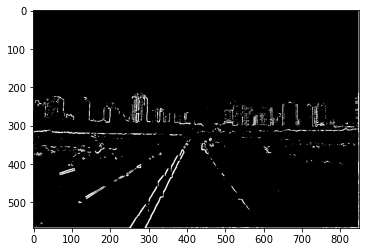

<ipython-input-40-2fd3e9954b46>:8: RuntimeWarning: divide by zero encountered in true_divide
  y = (rho - x * cos(theta)) / sin(theta)
<ipython-input-40-2fd3e9954b46>:8: RuntimeWarning: invalid value encountered in true_divide
  y = (rho - x * cos(theta)) / sin(theta)


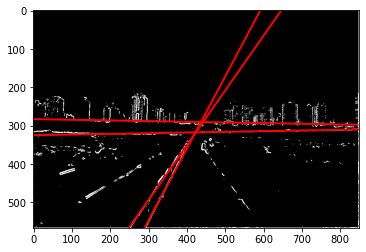

In [79]:
showImg(edges)

plt.imshow(edges, cmap='Greys_r')
for ra in sorted_ras:
    rho   = ra[0] - Maxrho   # Restore to original value
    angle = ra[1]
    theta = angle * (pi / 180)
    y_plot, x_plot = line_point(rho, theta)
    plt.plot(y_plot, x_plot, color='red', linewidth=2)    # plot (x,y) line

plt.show() 

# show (ρ,θ) heatmap:Hough Transform for lines 

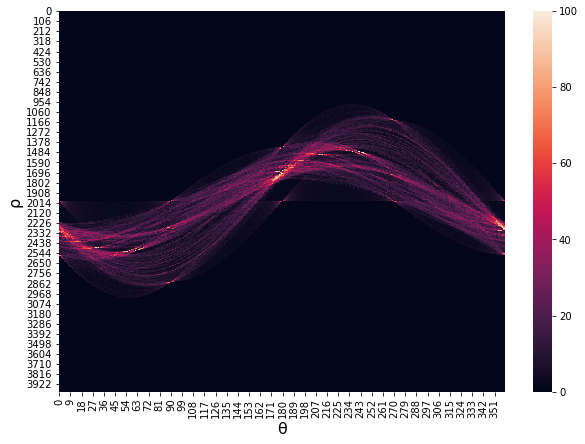

In [80]:
def show_heatmap(cnf_matrix):
    df_cm = pd.DataFrame(cnf_matrix)
    plt.figure(figsize = (10,7))
    
    heatmap = sn.heatmap(df_cm, vmin=0, vmax=100)
    plt.xlabel("θ", fontsize = 16)
    plt.ylabel("ρ", fontsize = 16) 
    plt.show()
show_heatmap(A)

# Hough Transform for cycles

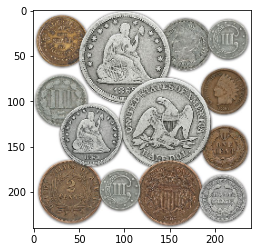

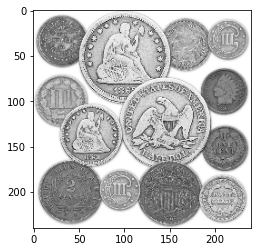

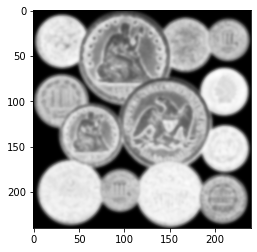

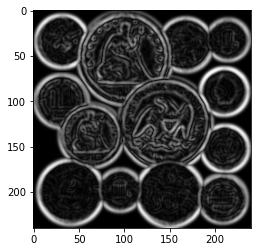

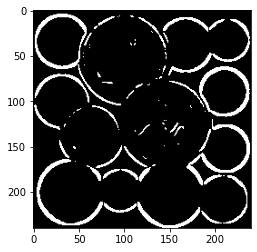

In [6]:
coins_gray     = readImg2Gray("pic4PR2/coins.jpg", resize=True)
coins_gaussian = gaussian_filter(255-coins_gray, kernel=11, sigma=1.5)
coins_sobel    = sobel(coins_gaussian)
coins_sobel_scaled = scale(coins_sobel, threshold=110)
showImg(coins_gaussian)
showImg(coins_sobel)
showImg(coins_sobel_scaled)
# #--------------------------------------------------------------------#
# mark_gray     = readImg2Gray("pic4PR2/mark.jpeg")
# mark_gaussian = gaussian_filter(mark_gray, kernel=13, sigma=1)
# showImg(mark_gaussian)

# Hough Transform for Circles

In [20]:
def cumulativeMatrix3D(edges, padding=2000):
    """
    :padding: padding the cumulative matrix record more information.
    :method:
        radius: >10
        angle : 0~360
        a = x - r * cos(angle*(pi/180))
        b = y - r * sin(angle*(pi/180))
    :return A:(a, b, radius) Cumulative Matrix
    """
    restore = padding//2
    
    radius = min(edges.shape[0], edges.shape[1])//2          # radius=minimum image length or width
    A      = np.zeros((edges.shape[0] + padding, edges.shape[1] + padding, radius))   # A padding=2000
    whiteIndexs = np.argwhere(edges == 255)                  # whiteIndexs:(x,y) gray scale=255 index 
    print("calculate point number:", len(whiteIndexs))
    
    # cumulative 
    n = 0
    for index in whiteIndexs:                     # (x,y)
        x, y = index[0], index[1]
        for r in range(10, radius):         
            for angle in range(360):        
                a = int(x - r * cos(angle*(pi/180)) + 0.5)            
                b = int(y - r * sin(angle*(pi/180)) + 0.5)
                
                if a >= A.shape[0] + restore:             # a, b bigger than padding
                    continue
                if b >= A.shape[1] + padding:
                    continue
                
                A[a + restore, b + restore, r] += 1
        
        if n%1000==0:
            print("{} finish".format(n))
        n += 1
    return A

In [21]:
def lineInfo(A, cyclenumber=30):
    """
    Get the (rho, angle) of max value in cumulative matrix.
    
    :cyclenumber: number of line  
    :return: list [[a,b,r], [a,b,r]]
    """
    sortedvalue = np.sort(A, axis=None, )[::-1][:cyclenumber]    

    abrs = []
    for sv in sortedvalue:
        abr = np.argwhere(A==sv)[0].tolist()
        if abr not in abrs:
            abrs.append(abr)

    return abrs

In [22]:
def deleteAdjacentCycle(abrs, diff=30):
    """
    Delete the adjacent Cycles.
    :method: if (a2 + b2 + r2)-(a1 + b1 + r1) < diff then delete cycle [a2,b2,r2].
    
    :diff: maximum difference
    :ras: [[a,b,r], [a,b,r]]
    :return: [[a,b,r], [a,b,r]]
    """
    
    wantdeletes = []
    sorted_abrs = sorted(abrs)
    for i in range(len(sorted_abrs)):
        for j in range(i+1, len(sorted_abrs)):
            if abs(sum(sorted_abrs[j]) - sum(sorted_abrs[i])) < diff:    # 
                wantdeletes.append(sorted_abrs[j])

    for wantdelete in wantdeletes:
        if wantdelete in sorted_abrs:
            sorted_abrs.remove(wantdelete)
    print(sorted_abrs)
#     print(sorted_abrs.pop(0))  # 作弊點
    return sorted_abrs

# Main: Hough Transform for lines

In [23]:
padding = 2000
edges  = coins_sobel_scaled
A      = cumulativeMatrix3D(edges, padding=padding)

calculate point number: 5842
0 finish
1000 finish
2000 finish
3000 finish
4000 finish
5000 finish


In [ ]:
abrs        = lineInfo(A, cyclenumber=1000)
# sorted_abrs = deleteAdjacentCycle(abrs, diff=10)

In [ ]:
showImg(edges)

figure, axes = plt.subplots()
axes.set_aspect(1)
for abr in abrs:
    axes.add_artist(plt.Circle((abr[1]-padding//2, abr[0]-padding//2), abr[2], fill=False, color='red', linewidth=2))

plt.imshow(edges, cmap='Greys_r')
plt.show()